# “mRMR with Normalized Mutual Information Relevance and Conditional Redundancy (NMI–CR mRMR)”

P=1:
 RF                       - DR=85.21%, FPR=0.20%, ACC=98.54%
 RF + mRMR(NMI+Red_cond) - DR=87.34%, FPR=0.18%, ACC=98.64%
P=2:
 RF                       - DR=90.08%, FPR=0.16%, ACC=98.84%
 RF + mRMR(NMI+Red_cond) - DR=91.20%, FPR=0.14%, ACC=98.91%
P=3:
 RF                       - DR=93.73%, FPR=0.13%, ACC=99.04%
 RF + mRMR(NMI+Red_cond) - DR=93.98%, FPR=0.12%, ACC=99.13%
P=4:
 RF                       - DR=96.18%, FPR=0.10%, ACC=99.22%
 RF + mRMR(NMI+Red_cond) - DR=96.14%, FPR=0.10%, ACC=99.27%
P=5:
 RF                       - DR=97.46%, FPR=0.09%, ACC=99.34%
 RF + mRMR(NMI+Red_cond) - DR=97.41%, FPR=0.08%, ACC=99.38%
P=6:
 RF                       - DR=98.46%, FPR=0.07%, ACC=99.46%
 RF + mRMR(NMI+Red_cond) - DR=98.45%, FPR=0.07%, ACC=99.52%


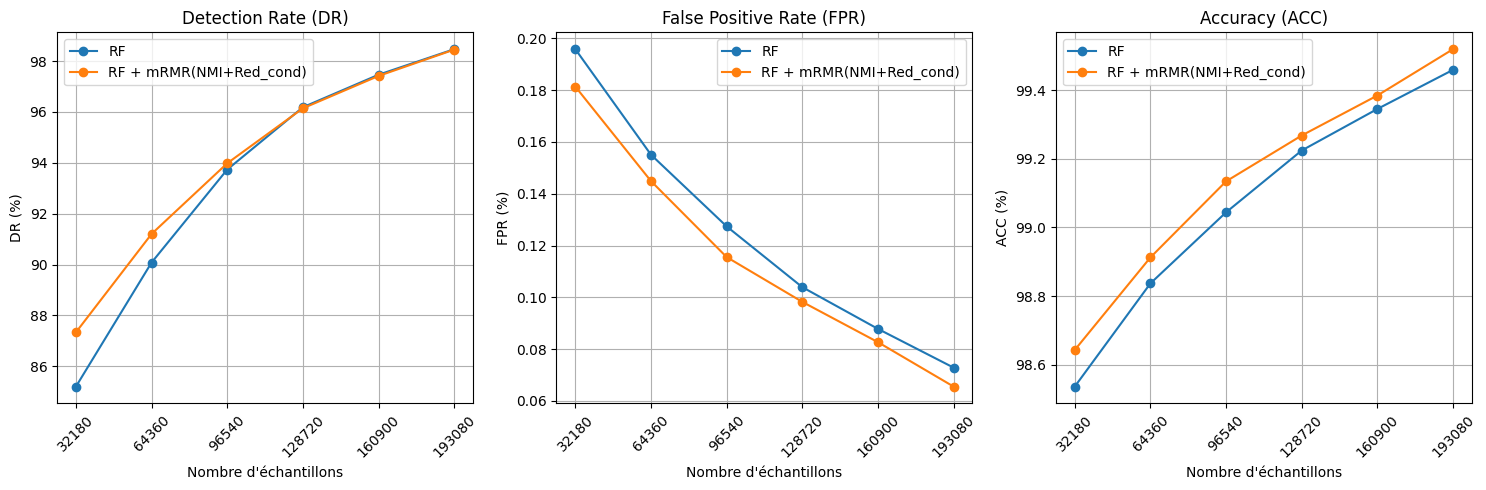

In [3]:
import pandas as pd
import numpy as np
import os
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import mutual_info_classif
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt

# ---------------------------------------------------------
# 1. Fonction utilitaire : chargement d'échantillons aléatoires
# ---------------------------------------------------------
def load_random_samples(filename, n_samples):
    df = pd.read_csv(filename)
    if len(df) < n_samples:
        raise ValueError(
            f"Not enough data in '{filename}': {len(df)} rows available, but {n_samples} required."
        )
    if len(df) > n_samples:
        return df.sample(n=n_samples, random_state=42)
    else:
        return df

# ---------------------------------------------------------
# 2. Helpers : discrétisation et CMI (I(X;Y|Z))
# ---------------------------------------------------------
def discretize_features(X, n_bins=10):
    """
    Discrétise chaque colonne de X en n_bins (quantiles).
    Retourne X_disc (entiers 0..n_bins-1).
    """
    X = np.asarray(X)
    n_samples, n_features = X.shape
    X_disc = np.zeros_like(X, dtype=int)

    for j in range(n_features):
        col = X[:, j]
        if np.all(col == col[0]):
            # feature constante
            X_disc[:, j] = 0
            continue

        # quantiles pour définir les bins
        edges = np.quantile(col, np.linspace(0, 1, n_bins + 1))
        edges = np.unique(edges)
        if len(edges) <= 2:
            X_disc[:, j] = 0
            continue

        cut_edges = edges[1:-1]
        X_disc[:, j] = np.digitize(col, cut_edges, right=False)

    return X_disc


def entropy_from_labels(y):
    """
    Entropie de Y (labels discrets) en nats.
    """
    y = np.asarray(y)
    values, counts = np.unique(y, return_counts=True)
    p = counts / counts.sum()
    return -np.sum(p * np.log(p + 1e-12))


def conditional_mutual_information_disc(x, y, z,
                                        n_x=None, n_y=None, n_z=None):
    """
    I(X;Y|Z) pour x,y,z discrets (entiers).
    Implémentation par histogramme 3D.
    """
    x = np.asarray(x, dtype=int)
    y = np.asarray(y, dtype=int)
    z = np.asarray(z, dtype=int)
    assert x.shape == y.shape == z.shape

    n = len(x)
    if n_x is None:
        n_x = int(x.max()) + 1
    if n_y is None:
        n_y = int(y.max()) + 1
    if n_z is None:
        n_z = int(z.max()) + 1

    counts = np.zeros((n_x, n_y, n_z), dtype=float)
    for i in range(n):
        counts[x[i], y[i], z[i]] += 1.0

    p_xyz = counts / n
    p_z  = p_xyz.sum(axis=(0, 1), keepdims=True)   # (1,1,n_z)
    p_xz = p_xyz.sum(axis=1, keepdims=True)        # (n_x,1,n_z)
    p_yz = p_xyz.sum(axis=0, keepdims=True)        # (1,n_y,n_z)

    with np.errstate(divide='ignore', invalid='ignore'):
        num = p_xyz * p_z          # p(x,y,z)*p(z)
        den = p_xz * p_yz          # p(x,z)*p(y,z)

        mask = (p_xyz > 0) & (p_xz > 0) & (p_yz > 0) & (p_z > 0)

        frac = np.zeros_like(p_xyz)
        frac[mask] = num[mask] / den[mask]

        log_term = np.zeros_like(p_xyz)
        log_term[mask] = np.log(frac[mask])

        cmi = (p_xyz * log_term).sum()

    return float(cmi)

# ---------------------------------------------------------
# 3. mRMR avec Relevance NMI + Redondance conditionnelle
# ---------------------------------------------------------
def mrmr_nmi_condred_feature_selection(X, y, k=20, n_bins=10):
    """
    Variante mRMR :
      - Relevance normalisée (NMI) : Rel(f) = I(f;Y) / H(Y)
      - Redondance conditionnelle : Red(f,S) = mean_s I(f;s | Y)

    X : (n_samples, n_features)
    y : (n_samples,)
    k : nombre de features à sélectionner
    n_bins : nb de bins pour discrétiser les features
    """
    X = np.asarray(X)
    y = np.asarray(y, dtype=int)
    n_samples, n_features = X.shape

    # --- 1) Relevance normalisée : NMI(f;Y) = I(f;Y) / H(Y) ---
    mi_fy = mutual_info_classif(X, y, random_state=42)
    H_y = entropy_from_labels(y) + 1e-12   # constante pour toutes les features
    relevance_nmi = mi_fy / H_y            # scores normalisés

    # --- 2) Préparation pour la CMI ---
    X_disc = discretize_features(X, n_bins=n_bins)
    y_disc = y  # labels déjà discrets (0..7)

    n_y = int(y_disc.max()) + 1
    n_x = n_bins   # approx nb d'états par feature

    selected_features = []
    remaining_features = list(range(n_features))

    for _ in range(k):
        scores = np.zeros(len(remaining_features))

        for idx, feat in enumerate(remaining_features):
            # relevance normalisée
            rel = relevance_nmi[feat]

            if selected_features:
                # moyenne des I(f;s | Y) pour s dans S
                cmi_list = []
                x_f = X_disc[:, feat]
                for s in selected_features:
                    x_s = X_disc[:, s]
                    cmi_fs_y = conditional_mutual_information_disc(
                        x_f, x_s, y_disc,
                        n_x=n_x, n_y=n_x, n_z=n_y
                    )
                    cmi_list.append(cmi_fs_y)

                red_cond = np.mean(cmi_list)
            else:
                red_cond = 0.0

            # Critère mRMR modifié : score = Rel_NMI - Red_cond
            scores[idx] = rel - red_cond

        best_idx = int(np.argmax(scores))
        best_feat = remaining_features[best_idx]
        selected_features.append(best_feat)
        remaining_features.pop(best_idx)

    return selected_features

# ---------------------------------------------------------
# 4. Chemins CICIoT2023
# ---------------------------------------------------------
train_path = '/kaggle/input/ciciot2023-data1/data1/train'
test_path  = '//kaggle/input/ciciot2023-data1/data1/test'

# ---------------------------------------------------------
# 5. Chargement des données de test
# ---------------------------------------------------------
benign_test     = pd.read_csv(os.path.join(test_path, 'Benign_test.csv')).drop(columns=['Label'], errors='ignore')
ddos_test       = pd.read_csv(os.path.join(test_path, 'DDoS_test.csv')).drop(columns=['Label'], errors='ignore')
dos_test        = pd.read_csv(os.path.join(test_path, 'DoS_test.csv')).drop(columns=['Label'], errors='ignore')
mirai_test      = pd.read_csv(os.path.join(test_path, 'Mirai_test.csv')).drop(columns=['Label'], errors='ignore')
recon_test      = pd.read_csv(os.path.join(test_path, 'Recon_test.csv')).drop(columns=['Label'], errors='ignore')
spoofing_test   = pd.read_csv(os.path.join(test_path, 'Spoofing_test.csv')).drop(columns=['Label'], errors='ignore')
webbased_test   = pd.read_csv(os.path.join(test_path, 'Web-based_test.csv')).drop(columns=['Label'], errors='ignore')
bruteforce_test = pd.read_csv(os.path.join(test_path, 'Brute_Force_test.csv')).drop(columns=['Label'], errors='ignore')

# Labels test
benign_test_labels     = np.zeros(len(benign_test), dtype=int)
ddos_test_labels       = np.ones(len(ddos_test), dtype=int)
dos_test_labels        = np.full(len(dos_test), 2, dtype=int)
mirai_test_labels      = np.full(len(mirai_test), 3, dtype=int)
recon_test_labels      = np.full(len(recon_test), 4, dtype=int)
spoofing_test_labels   = np.full(len(spoofing_test), 5, dtype=int)
webbased_test_labels   = np.full(len(webbased_test), 6, dtype=int)
bruteforce_test_labels = np.full(len(bruteforce_test), 7, dtype=int)

TestMatrix = pd.concat([
    benign_test, ddos_test, dos_test, mirai_test,
    recon_test, spoofing_test, webbased_test, bruteforce_test
], ignore_index=True)

TestLabels = np.concatenate([
    benign_test_labels, ddos_test_labels, dos_test_labels, mirai_test_labels,
    recon_test_labels, spoofing_test_labels, webbased_test_labels, bruteforce_test_labels
])

# Nettoyage test
TestMatrix.replace([np.inf, -np.inf], np.nan, inplace=True)
TestMatrix.fillna(TestMatrix.mean(), inplace=True)

# ---------------------------------------------------------
# 6. Listes métriques
# ---------------------------------------------------------
DR_list_RF = []
FPR_list_RF = []
ACC_list_RF = []

DR_list_MRMR_NMI_RF = []
FPR_list_MRMR_NMI_RF = []
ACC_list_MRMR_NMI_RF = []

sample_count_list = []

# ---------------------------------------------------------
# 7. Boucle P = 1..6
# ---------------------------------------------------------
for P in range(1, 7):
    benign_train = load_random_samples(os.path.join(train_path, 'Benign_train.csv'), 7100*P).drop(columns=['Label'], errors='ignore')
    ddos_train = load_random_samples(os.path.join(train_path, 'DDoS_train.csv'), 8600*P).drop(columns=['Label'], errors='ignore')
    dos_train = load_random_samples(os.path.join(train_path, 'DoS_train.csv'), 4160*P).drop(columns=['Label'], errors='ignore')
    mirai_train = load_random_samples(os.path.join(train_path, 'Mirai_train.csv'),2000*P).drop(columns=['Label'], errors='ignore')
    recon_train = load_random_samples(os.path.join(train_path, 'Recon_train.csv'), 3000*P).drop(columns=['Label'], errors='ignore')
    spoofing_train = load_random_samples(os.path.join(train_path, 'Spoofing_train.csv'), 6600*P).drop(columns=['Label'], errors='ignore')
    webbased_train = load_random_samples(os.path.join(train_path, 'Web-based_train.csv'), 380*P).drop(columns=['Label'], errors='ignore')
    bruteforce_train = load_random_samples(os.path.join(train_path, 'Brute_Force_train.csv'), 340*P).drop(columns=['Label'], errors='ignore')

    benign_labels     = np.zeros(len(benign_train), dtype=int)
    ddos_labels       = np.ones(len(ddos_train), dtype=int)
    dos_labels        = np.full(len(dos_train), 2, dtype=int)
    mirai_labels      = np.full(len(mirai_train), 3, dtype=int)
    recon_labels      = np.full(len(recon_train), 4, dtype=int)
    spoofing_labels   = np.full(len(spoofing_train), 5, dtype=int)
    webbased_labels   = np.full(len(webbased_train), 6, dtype=int)
    bruteforce_labels = np.full(len(bruteforce_train), 7, dtype=int)

    TrainMatrix = pd.concat([
        benign_train, ddos_train, dos_train, mirai_train,
        recon_train, spoofing_train, webbased_train, bruteforce_train
    ], ignore_index=True)

    TrainLabels = np.concatenate([
        benign_labels, ddos_labels, dos_labels, mirai_labels,
        recon_labels, spoofing_labels, webbased_labels, bruteforce_labels
    ])

    # Nettoyage train
    TrainMatrix.replace([np.inf, -np.inf], np.nan, inplace=True)
    TrainMatrix.fillna(TrainMatrix.mean(), inplace=True)

    # ---------------- RF standard ----------------
    rf = RandomForestClassifier(n_estimators=100, random_state=42)
    rf.fit(TrainMatrix, TrainLabels)
    pred_labels = rf.predict(TestMatrix)

    conf_mat = confusion_matrix(TestLabels, pred_labels, labels=np.unique(TestLabels))
    TP = np.diag(conf_mat)
    FN = np.sum(conf_mat, axis=1) - TP
    FP = np.sum(conf_mat, axis=0) - TP
    TN = np.sum(conf_mat) - (TP + FP + FN)

    DR_RF = np.mean(TP / (TP + FN)) * 100
    FPR_RF = np.mean(FP / (FP + TN)) * 100
    ACC_RF = np.sum(TP) / np.sum(conf_mat) * 100

    # ---------------- RF + mRMR(NMI + Red_cond) ----------------
    k = 20
    selected_mrmr_nmi = mrmr_nmi_condred_feature_selection(
        TrainMatrix.values,
        TrainLabels,
        k=k,
        n_bins=10
    )

    TrainMatrix_mrmr = TrainMatrix.iloc[:, selected_mrmr_nmi].values
    TestMatrix_mrmr  = TestMatrix.iloc[:, selected_mrmr_nmi].values

    rf_mrmr = RandomForestClassifier(n_estimators=100, random_state=42)
    rf_mrmr.fit(TrainMatrix_mrmr, TrainLabels)
    pred_labels_mrmr = rf_mrmr.predict(TestMatrix_mrmr)

    conf_mat_mrmr = confusion_matrix(TestLabels, pred_labels_mrmr, labels=np.unique(TestLabels))
    TP_m = np.diag(conf_mat_mrmr)
    FN_m = np.sum(conf_mat_mrmr, axis=1) - TP_m
    FP_m = np.sum(conf_mat_mrmr, axis=0) - TP_m
    TN_m = np.sum(conf_mat_mrmr) - (TP_m + FP_m + FN_m)

    DR_MRMR_NMI_RF = np.mean(TP_m / (TP_m + FN_m)) * 100
    FPR_MRMR_NMI_RF = np.mean(FP_m / (FP_m + TN_m)) * 100
    ACC_MRMR_NMI_RF = np.sum(TP_m) / np.sum(conf_mat_mrmr) * 100

    print(f"P={P}:")
    print(f" RF                       - DR={DR_RF:.2f}%, FPR={FPR_RF:.2f}%, ACC={ACC_RF:.2f}%")
    print(f" RF + mRMR(NMI+Red_cond) - DR={DR_MRMR_NMI_RF:.2f}%, FPR={FPR_MRMR_NMI_RF:.2f}%, ACC={ACC_MRMR_NMI_RF:.2f}%")

    DR_list_RF.append(DR_RF)
    FPR_list_RF.append(FPR_RF)
    ACC_list_RF.append(ACC_RF)

    DR_list_MRMR_NMI_RF.append(DR_MRMR_NMI_RF)
    FPR_list_MRMR_NMI_RF.append(FPR_MRMR_NMI_RF)
    ACC_list_MRMR_NMI_RF.append(ACC_MRMR_NMI_RF)

    sample_count_list.append(len(TrainMatrix))

# ---------------------------------------------------------
# 8. Courbes comparatives
# ---------------------------------------------------------
plt.figure(figsize=(15, 5))

# DR
plt.subplot(1, 3, 1)
plt.plot(sample_count_list, DR_list_RF, marker='o', label="RF")
plt.plot(sample_count_list, DR_list_MRMR_NMI_RF, marker='o', label="RF + mRMR(NMI+Red_cond)")
plt.xlabel("Nombre d'échantillons")
plt.ylabel("DR (%)")
plt.title("Detection Rate (DR)")
plt.legend()
plt.grid(True)
plt.xticks(sample_count_list, rotation=45)
plt.locator_params(axis='x', nbins=len(sample_count_list))

# FPR
plt.subplot(1, 3, 2)
plt.plot(sample_count_list, FPR_list_RF, marker='o', label="RF")
plt.plot(sample_count_list, FPR_list_MRMR_NMI_RF, marker='o', label="RF + mRMR(NMI+Red_cond)")
plt.xlabel("Nombre d'échantillons")
plt.ylabel("FPR (%)")
plt.title("False Positive Rate (FPR)")
plt.legend()
plt.grid(True)
plt.xticks(sample_count_list, rotation=45)
plt.locator_params(axis='x', nbins=len(sample_count_list))

# ACC
plt.subplot(1, 3, 3)
plt.plot(sample_count_list, ACC_list_RF, marker='o', label="RF")
plt.plot(sample_count_list, ACC_list_MRMR_NMI_RF, marker='o', label="RF + mRMR(NMI+Red_cond)")
plt.xlabel("Nombre d'échantillons")
plt.ylabel("ACC (%)")
plt.title("Accuracy (ACC)")
plt.legend()
plt.grid(True)
plt.xticks(sample_count_list, rotation=45)
plt.locator_params(axis='x', nbins=len(sample_count_list))

plt.tight_layout()
plt.show()


# “mRMR with Conditional Relevance and Normalized Mutual Information Redundancy (CR–NMI mRMR)”

P=1:
 RF                          - DR=85.21%, FPR=0.20%, ACC=98.54%
 RF + mRMR(CondRel+RedNMI)  - DR=87.18%, FPR=0.19%, ACC=98.59%
P=2:
 RF                          - DR=90.08%, FPR=0.16%, ACC=98.84%
 RF + mRMR(CondRel+RedNMI)  - DR=91.18%, FPR=0.15%, ACC=98.90%
P=3:
 RF                          - DR=93.73%, FPR=0.13%, ACC=99.04%
 RF + mRMR(CondRel+RedNMI)  - DR=94.03%, FPR=0.12%, ACC=99.11%
P=4:
 RF                          - DR=96.18%, FPR=0.10%, ACC=99.22%
 RF + mRMR(CondRel+RedNMI)  - DR=96.10%, FPR=0.10%, ACC=99.25%
P=5:
 RF                          - DR=97.46%, FPR=0.09%, ACC=99.34%
 RF + mRMR(CondRel+RedNMI)  - DR=97.44%, FPR=0.08%, ACC=99.39%
P=6:
 RF                          - DR=98.46%, FPR=0.07%, ACC=99.46%
 RF + mRMR(CondRel+RedNMI)  - DR=98.47%, FPR=0.07%, ACC=99.51%


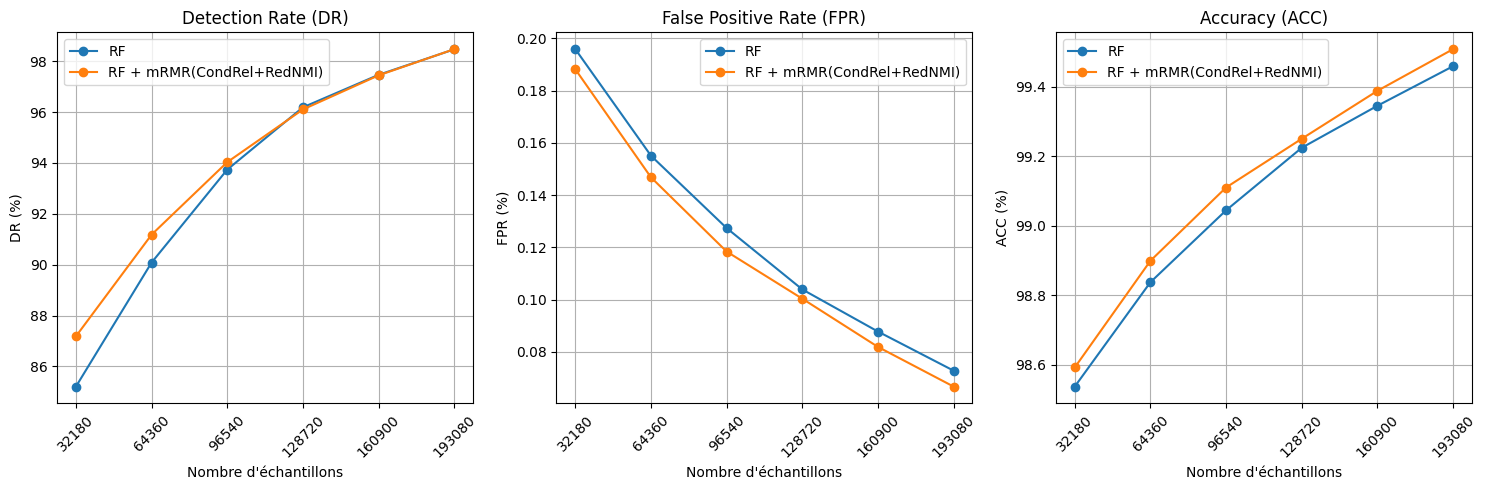

In [2]:
import pandas as pd
import numpy as np
import os
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt

# ---------------------------------------------------------
# 1. Fonction utilitaire : chargement d'échantillons aléatoires
# ---------------------------------------------------------
def load_random_samples(filename, n_samples):
    df = pd.read_csv(filename)
    if len(df) < n_samples:
        raise ValueError(
            f"Not enough data in '{filename}': {len(df)} rows available, but {n_samples} required."
        )
    if len(df) > n_samples:
        return df.sample(n=n_samples, random_state=42)
    else:
        return df

# ---------------------------------------------------------
# 2. Helpers : discrétisation, entropie, MI, CMI (variables discrètes)
# ---------------------------------------------------------
def discretize_features(X, n_bins=10):
    """
    Discrétise chaque colonne de X en n_bins (quantiles).
    Retourne X_disc (entiers 0..n_bins-1).
    """
    X = np.asarray(X)
    n_samples, n_features = X.shape
    X_disc = np.zeros_like(X, dtype=int)

    for j in range(n_features):
        col = X[:, j]
        if np.all(col == col[0]):
            # feature constante
            X_disc[:, j] = 0
            continue

        # quantiles pour définir les bins
        edges = np.quantile(col, np.linspace(0, 1, n_bins + 1))
        edges = np.unique(edges)
        if len(edges) <= 2:
            X_disc[:, j] = 0
            continue

        cut_edges = edges[1:-1]
        X_disc[:, j] = np.digitize(col, cut_edges, right=False)

    return X_disc


def entropy_from_labels(y):
    """
    Entropie de y (discret) en nats, avec clamp numérique à >= 0.
    """
    y = np.asarray(y)
    values, counts = np.unique(y, return_counts=True)
    p = counts / counts.sum()
    ent = -np.sum(p * np.log(p + 1e-12))
    if ent < 0:
        ent = 0.0
    return float(ent)


def mutual_information_disc(x, y, n_x=None, n_y=None):
    """
    I(X;Y) pour x,y discrets (entiers).
    """
    x = np.asarray(x, dtype=int)
    y = np.asarray(y, dtype=int)
    assert x.shape == y.shape

    n = len(x)
    if n_x is None:
        n_x = int(x.max()) + 1
    if n_y is None:
        n_y = int(y.max()) + 1

    counts = np.zeros((n_x, n_y), dtype=float)
    for i in range(n):
        counts[x[i], y[i]] += 1.0

    p_xy = counts / n
    p_x = p_xy.sum(axis=1, keepdims=True)  # (n_x,1)
    p_y = p_xy.sum(axis=0, keepdims=True)  # (1,n_y)

    with np.errstate(divide='ignore', invalid='ignore'):
        den = p_x @ p_y
        mask = (p_xy > 0) & (den > 0)
        frac = np.zeros_like(p_xy)
        frac[mask] = p_xy[mask] / den[mask]
        log_term = np.zeros_like(p_xy)
        log_term[mask] = np.log(frac[mask])
        mi = (p_xy * log_term).sum()

    return float(mi)


def conditional_mutual_information_disc(x, y, z,
                                        n_x=None, n_y=None, n_z=None):
    """
    I(X;Y|Z) pour x,y,z discrets (entiers) via histogramme 3D.
    """
    x = np.asarray(x, dtype=int)
    y = np.asarray(y, dtype=int)
    z = np.asarray(z, dtype=int)
    assert x.shape == y.shape == z.shape

    n = len(x)
    if n_x is None:
        n_x = int(x.max()) + 1
    if n_y is None:
        n_y = int(y.max()) + 1
    if n_z is None:
        n_z = int(z.max()) + 1

    counts = np.zeros((n_x, n_y, n_z), dtype=float)
    for i in range(n):
        counts[x[i], y[i], z[i]] += 1.0

    p_xyz = counts / n
    p_z  = p_xyz.sum(axis=(0, 1), keepdims=True)   # (1,1,n_z)
    p_xz = p_xyz.sum(axis=1, keepdims=True)        # (n_x,1,n_z)
    p_yz = p_xyz.sum(axis=0, keepdims=True)        # (1,n_y,n_z)

    with np.errstate(divide='ignore', invalid='ignore'):
        num = p_xyz * p_z          # p(x,y,z)*p(z)
        den = p_xz * p_yz          # p(x,z)*p(y,z)

        mask = (p_xyz > 0) & (p_xz > 0) & (p_yz > 0) & (p_z > 0)

        frac = np.zeros_like(p_xyz)
        frac[mask] = num[mask] / den[mask]

        log_term = np.zeros_like(p_xyz)
        log_term[mask] = np.log(frac[mask])

        cmi = (p_xyz * log_term).sum()

    return float(cmi)

# ---------------------------------------------------------
# 3. mRMR avec Relevance conditionnelle + Redondance NMI
# ---------------------------------------------------------
def mrmr_condrel_normred_feature_selection(X, y, k=20, n_bins=10):
    """
    Variante mRMR :
      - Relevance conditionnelle :
          si S = ∅      : Rel(f) = I(f;Y)
          sinon         : Rel(f) = mean_s I(f;Y | s)
      - Redondance normalisée (NMI) :
          NMI(f,s) = I(f;s) / sqrt(H(f)*H(s))
          Red(f,S) = mean_s NMI(f,s)

      Score mRMR : J(f) = Rel_cond(f) - Red_NMI(f,S)
    """
    X = np.asarray(X)
    y = np.asarray(y, dtype=int)
    n_samples, n_features = X.shape

    # Discrétisation pour MI / CMI
    X_disc = discretize_features(X, n_bins=n_bins)
    y_disc = y

    # Entropies des features (pour NMI), sécurisées
    H_feat = np.zeros(n_features)
    for j in range(n_features):
        H_feat[j] = entropy_from_labels(X_disc[:, j])

    n_y = int(y_disc.max()) + 1

    selected_features = []
    remaining_features = list(range(n_features))

    for _ in range(k):
        scores = np.zeros(len(remaining_features))

        for idx, feat in enumerate(remaining_features):
            x_f = X_disc[:, feat]

            # ----- Relevance conditionnelle -----
            if not selected_features:
                # pas encore de feature sélectionnée → MI simple
                rel = mutual_information_disc(x_f, y_disc)
            else:
                cmi_list = []
                for s in selected_features:
                    z_s = X_disc[:, s]
                    cmi_fy_s = conditional_mutual_information_disc(
                        x_f, y_disc, z_s,
                        n_x=None, n_y=n_y, n_z=None
                    )
                    cmi_list.append(cmi_fy_s)
                rel = np.mean(cmi_list)

            # ----- Redondance normalisée (NMI) -----
            if selected_features:
                red_list = []
                H_f = max(H_feat[feat], 0.0)  # sécurité
                for s in selected_features:
                    x_s = X_disc[:, s]
                    mi_fs = mutual_information_disc(x_f, x_s)
                    H_s = max(H_feat[s], 0.0)

                    prod = H_f * H_s
                    if prod <= 0:
                        # Si une entropie est ~0 (feature quasi constante),
                        # on considère la NMI ≈ 0 (pas de pénalisation).
                        nmi_fs = 0.0
                    else:
                        denom = np.sqrt(prod) + 1e-12
                        nmi_fs = mi_fs / denom

                    red_list.append(nmi_fs)
                red = np.mean(red_list)
            else:
                red = 0.0

            # Critère mRMR modifié
            scores[idx] = rel - red

        best_idx = int(np.argmax(scores))
        best_feat = remaining_features[best_idx]
        selected_features.append(best_feat)
        remaining_features.pop(best_idx)

    return selected_features

# ---------------------------------------------------------
# 4. Chemins CICIoT2023
# ---------------------------------------------------------
train_path = '/kaggle/input/ciciot2023-data1/data1/train'
test_path  = '//kaggle/input/ciciot2023-data1/data1/test'
# ---------------------------------------------------------
# 5. Chargement des données de test
# ---------------------------------------------------------
benign_test     = pd.read_csv(os.path.join(test_path, 'Benign_test.csv')).drop(columns=['Label'], errors='ignore')
ddos_test       = pd.read_csv(os.path.join(test_path, 'DDoS_test.csv')).drop(columns=['Label'], errors='ignore')
dos_test        = pd.read_csv(os.path.join(test_path, 'DoS_test.csv')).drop(columns=['Label'], errors='ignore')
mirai_test      = pd.read_csv(os.path.join(test_path, 'Mirai_test.csv')).drop(columns=['Label'], errors='ignore')
recon_test      = pd.read_csv(os.path.join(test_path, 'Recon_test.csv')).drop(columns=['Label'], errors='ignore')
spoofing_test   = pd.read_csv(os.path.join(test_path, 'Spoofing_test.csv')).drop(columns=['Label'], errors='ignore')
webbased_test   = pd.read_csv(os.path.join(test_path, 'Web-based_test.csv')).drop(columns=['Label'], errors='ignore')
bruteforce_test = pd.read_csv(os.path.join(test_path, 'Brute_Force_test.csv')).drop(columns=['Label'], errors='ignore')

# Labels test
benign_test_labels     = np.zeros(len(benign_test), dtype=int)
ddos_test_labels       = np.ones(len(ddos_test), dtype=int)
dos_test_labels        = np.full(len(dos_test), 2, dtype=int)
mirai_test_labels      = np.full(len(mirai_test), 3, dtype=int)
recon_test_labels      = np.full(len(recon_test), 4, dtype=int)
spoofing_test_labels   = np.full(len(spoofing_test), 5, dtype=int)
webbased_test_labels   = np.full(len(webbased_test), 6, dtype=int)
bruteforce_test_labels = np.full(len(bruteforce_test), 7, dtype=int)

TestMatrix = pd.concat([
    benign_test, ddos_test, dos_test, mirai_test,
    recon_test, spoofing_test, webbased_test, bruteforce_test
], ignore_index=True)

TestLabels = np.concatenate([
    benign_test_labels, ddos_test_labels, dos_test_labels, mirai_test_labels,
    recon_test_labels, spoofing_test_labels, webbased_test_labels, bruteforce_test_labels
])

# Nettoyage test (NaN / inf)
TestMatrix.replace([np.inf, -np.inf], np.nan, inplace=True)
TestMatrix.fillna(TestMatrix.mean(), inplace=True)

# ---------------------------------------------------------
# 6. Listes métriques
# ---------------------------------------------------------
DR_list_RF = []
FPR_list_RF = []
ACC_list_RF = []

DR_list_MRMR_CRNMI_RF = []
FPR_list_MRMR_CRNMI_RF = []
ACC_list_MRMR_CRNMI_RF = []

sample_count_list = []

# ---------------------------------------------------------
# 7. Boucle P = 1..6
# ---------------------------------------------------------
for P in range(1, 7):
    benign_train = load_random_samples(os.path.join(train_path, 'Benign_train.csv'), 7100*P).drop(columns=['Label'], errors='ignore')
    ddos_train = load_random_samples(os.path.join(train_path, 'DDoS_train.csv'), 8600*P).drop(columns=['Label'], errors='ignore')
    dos_train = load_random_samples(os.path.join(train_path, 'DoS_train.csv'), 4160*P).drop(columns=['Label'], errors='ignore')
    mirai_train = load_random_samples(os.path.join(train_path, 'Mirai_train.csv'),2000*P).drop(columns=['Label'], errors='ignore')
    recon_train = load_random_samples(os.path.join(train_path, 'Recon_train.csv'), 3000*P).drop(columns=['Label'], errors='ignore')
    spoofing_train = load_random_samples(os.path.join(train_path, 'Spoofing_train.csv'), 6600*P).drop(columns=['Label'], errors='ignore')
    webbased_train = load_random_samples(os.path.join(train_path, 'Web-based_train.csv'), 380*P).drop(columns=['Label'], errors='ignore')
    bruteforce_train = load_random_samples(os.path.join(train_path, 'Brute_Force_train.csv'), 340*P).drop(columns=['Label'], errors='ignore')

    benign_labels     = np.zeros(len(benign_train), dtype=int)
    ddos_labels       = np.ones(len(ddos_train), dtype=int)
    dos_labels        = np.full(len(dos_train), 2, dtype=int)
    mirai_labels      = np.full(len(mirai_train), 3, dtype=int)
    recon_labels      = np.full(len(recon_train), 4, dtype=int)
    spoofing_labels   = np.full(len(spoofing_train), 5, dtype=int)
    webbased_labels   = np.full(len(webbased_train), 6, dtype=int)
    bruteforce_labels = np.full(len(bruteforce_train), 7, dtype=int)

    TrainMatrix = pd.concat([
        benign_train, ddos_train, dos_train, mirai_train,
        recon_train, spoofing_train, webbased_train, bruteforce_train
    ], ignore_index=True)

    TrainLabels = np.concatenate([
        benign_labels, ddos_labels, dos_labels, mirai_labels,
        recon_labels, spoofing_labels, webbased_labels, bruteforce_labels
    ])

    # Nettoyage train
    TrainMatrix.replace([np.inf, -np.inf], np.nan, inplace=True)
    TrainMatrix.fillna(TrainMatrix.mean(), inplace=True)

    # ---------------- RF standard ----------------
    rf = RandomForestClassifier(n_estimators=100, random_state=42)
    rf.fit(TrainMatrix, TrainLabels)
    pred_labels = rf.predict(TestMatrix)

    conf_mat = confusion_matrix(TestLabels, pred_labels, labels=np.unique(TestLabels))
    TP = np.diag(conf_mat)
    FN = np.sum(conf_mat, axis=1) - TP
    FP = np.sum(conf_mat, axis=0) - TP
    TN = np.sum(conf_mat) - (TP + FP + FN)

    DR_RF = np.mean(TP / (TP + FN)) * 100
    FPR_RF = np.mean(FP / (FP + TN)) * 100
    ACC_RF = np.sum(TP) / np.sum(conf_mat) * 100

    # ---------------- RF + mRMR(CondRel + RedNMI) ----------------
    k = 20
    selected_mrmr_crnmi = mrmr_condrel_normred_feature_selection(
        TrainMatrix.values,
        TrainLabels,
        k=k,
        n_bins=10
    )

    TrainMatrix_mrmr = TrainMatrix.iloc[:, selected_mrmr_crnmi].values
    TestMatrix_mrmr  = TestMatrix.iloc[:, selected_mrmr_crnmi].values

    rf_mrmr = RandomForestClassifier(n_estimators=100, random_state=42)
    rf_mrmr.fit(TrainMatrix_mrmr, TrainLabels)
    pred_labels_mrmr = rf_mrmr.predict(TestMatrix_mrmr)

    conf_mat_mrmr = confusion_matrix(TestLabels, pred_labels_mrmr, labels=np.unique(TestLabels))
    TP_m = np.diag(conf_mat_mrmr)
    FN_m = np.sum(conf_mat_mrmr, axis=1) - TP_m
    FP_m = np.sum(conf_mat_mrmr, axis=0) - TP_m
    TN_m = np.sum(conf_mat_mrmr) - (TP_m + FP_m + FN_m)

    DR_MRMR_CRNMI_RF = np.mean(TP_m / (TP_m + FN_m)) * 100
    FPR_MRMR_CRNMI_RF = np.mean(FP_m / (FP_m + TN_m)) * 100
    ACC_MRMR_CRNMI_RF = np.sum(TP_m) / np.sum(conf_mat_mrmr) * 100

    print(f"P={P}:")
    print(f" RF                          - DR={DR_RF:.2f}%, FPR={FPR_RF:.2f}%, ACC={ACC_RF:.2f}%")
    print(f" RF + mRMR(CondRel+RedNMI)  - DR={DR_MRMR_CRNMI_RF:.2f}%, FPR={FPR_MRMR_CRNMI_RF:.2f}%, ACC={ACC_MRMR_CRNMI_RF:.2f}%")

    DR_list_RF.append(DR_RF)
    FPR_list_RF.append(FPR_RF)
    ACC_list_RF.append(ACC_RF)

    DR_list_MRMR_CRNMI_RF.append(DR_MRMR_CRNMI_RF)
    FPR_list_MRMR_CRNMI_RF.append(FPR_MRMR_CRNMI_RF)
    ACC_list_MRMR_CRNMI_RF.append(ACC_MRMR_CRNMI_RF)

    sample_count_list.append(len(TrainMatrix))

# ---------------------------------------------------------
# 8. Courbes comparatives
# ---------------------------------------------------------
plt.figure(figsize=(15, 5))

# DR
plt.subplot(1, 3, 1)
plt.plot(sample_count_list, DR_list_RF, marker='o', label="RF")
plt.plot(sample_count_list, DR_list_MRMR_CRNMI_RF, marker='o', label="RF + mRMR(CondRel+RedNMI)")
plt.xlabel("Nombre d'échantillons")
plt.ylabel("DR (%)")
plt.title("Detection Rate (DR)")
plt.legend()
plt.grid(True)
plt.xticks(sample_count_list, rotation=45)
plt.locator_params(axis='x', nbins=len(sample_count_list))

# FPR
plt.subplot(1, 3, 2)
plt.plot(sample_count_list, FPR_list_RF, marker='o', label="RF")
plt.plot(sample_count_list, FPR_list_MRMR_CRNMI_RF, marker='o', label="RF + mRMR(CondRel+RedNMI)")
plt.xlabel("Nombre d'échantillons")
plt.ylabel("FPR (%)")
plt.title("False Positive Rate (FPR)")
plt.legend()
plt.grid(True)
plt.xticks(sample_count_list, rotation=45)
plt.locator_params(axis='x', nbins=len(sample_count_list))

# ACC
plt.subplot(1, 3, 3)
plt.plot(sample_count_list, ACC_list_RF, marker='o', label="RF")
plt.plot(sample_count_list, ACC_list_MRMR_CRNMI_RF, marker='o', label="RF + mRMR(CondRel+RedNMI)")
plt.xlabel("Nombre d'échantillons")
plt.ylabel("ACC (%)")
plt.title("Accuracy (ACC)")
plt.legend()
plt.grid(True)
plt.xticks(sample_count_list, rotation=45)
plt.locator_params(axis='x', nbins=len(sample_count_list))

plt.tight_layout()
plt.show()
